# 数据预处理

In [1]:
import h5py
import numpy as np
import keras
from keras.layers import Input, Dense, ZeroPadding2D, Dropout, Activation, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.models import Model
import matplotlib.pyplot as plt
%matplotlib inline

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

file = h5py.File('DB2/fused_200_96.h5','r')
imageData   = file['imageData'][:]
imageLabel  = file['imageLabel'][:]  
file.close()

# 随机打乱数据和标签
N = imageData.shape[0]
index = np.random.permutation(N)
data  = imageData[index,:,:]
label = imageLabel[index]

# 对数据升维,标签one-hot
data  = np.expand_dims(data, axis=3)
label = convert_to_one_hot(label,49).T

# 划分数据集
N = data.shape[0]
num_train = round(N*0.8)
X_train = data[0:num_train,:,:,:]
Y_train = label[0:num_train,:]
X_test  = data[num_train:N,:,:,:]
Y_test  = label[num_train:N,:]

print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

X_train shape: (9531, 200, 96, 1)
Y_train shape: (9531, 49)
X_test shape: (2383, 200, 96, 1)
Y_test shape: (2383, 49)


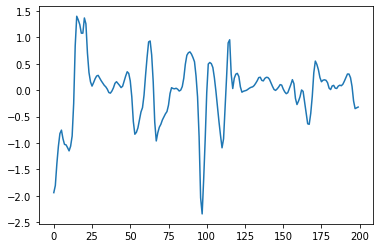

In [7]:
plt.plot(X_train[0, :, 10, 0])

In [2]:
#写一个LossHistory类，保存loss和acc
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

# 建立模型

In [3]:
def CNN(input_shape=(200,96,1), classes=49): 
    X_input = Input(input_shape)
    
    X = Conv2D(filters=32, kernel_size=(20,3), strides=(1,1),padding='same',activation='relu', name='conv1')(X_input)
    X = MaxPooling2D((10,1), strides=(10,1), name='pool1')(X)

    X = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1),padding='same', activation='relu',name='conv2')(X)
    X = MaxPooling2D((3,2), strides=(3,2), name='pool2')(X)
    
    X = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1),padding='same', activation='relu',name='conv3')(X)
    X = MaxPooling2D((2,2), strides=(2,2), name='pool3')(X)
    
    X = Flatten(name='flatten')(X)
    X = Dropout(0.5)(X)
    X = Dense(128,activation='relu',name='fc1')(X)
    X = Dropout(0.5)(X)
    X = Dense(classes, activation='softmax', name='fc2')(X)
    
    model = Model(inputs=X_input, outputs=X, name='CNN')
    return model
    
model = CNN(input_shape = (200, 96, 1), classes = 49)
model.summary()


Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 96, 1)]      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 200, 96, 32)       1952      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 20, 96, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 20, 96, 64)        18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 6, 48, 64)         0         
_________________________________________________________________
conv3 (Conv2D)               (None, 6, 48, 128)        73856     
_________________________________________________________________
pool3 (MaxPooling2D)         (None, 3, 24, 128)        0       

# 训练原始数据

In [4]:
import time
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"
start = time.time()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = LossHistory() # 创建一个history实例

model.fit(X_train, Y_train, epochs=100, batch_size=64, verbose=1, 
            validation_data=(X_test, Y_test),callbacks=[history])

preds_train = model.evaluate(X_train, Y_train)
print("Train Loss = " + str(preds_train[0]))
print("Train Accuracy = " + str(preds_train[1]))

preds_test  = model.evaluate(X_test, Y_test)
print("Test Loss = " + str(preds_test[0]))
print("Test Accuracy = " + str(preds_test[1]))

end = time.time()
print("time:",end-start)


Epoch 1/100
149/149 [==============================] - 76s 509ms/step - loss: 3.0309 - accuracy: 0.1995 - val_loss: 1.5988 - val_accuracy: 0.5657
Epoch 2/100
149/149 [==============================] - 75s 502ms/step - loss: 1.7561 - accuracy: 0.4793 - val_loss: 0.8219 - val_accuracy: 0.7612
Epoch 3/100
149/149 [==============================] - 75s 502ms/step - loss: 1.2128 - accuracy: 0.6206 - val_loss: 0.5819 - val_accuracy: 0.8359
Epoch 4/100
149/149 [==============================] - 74s 500ms/step - loss: 0.9629 - accuracy: 0.6863 - val_loss: 0.4674 - val_accuracy: 0.8594
Epoch 5/100
149/149 [==============================] - 75s 501ms/step - loss: 0.8257 - accuracy: 0.7250 - val_loss: 0.3960 - val_accuracy: 0.8703
Epoch 6/100
149/149 [==============================] - 74s 499ms/step - loss: 0.7211 - accuracy: 0.7578 - val_loss: 0.3762 - val_accuracy: 0.8682
Epoch 7/100
149/149 [==============================] - 74s 498ms/step - loss: 0.6629 - accuracy: 0.7774 - val_loss: 0.3579 -

In [15]:
model.save('model/wavelet_acc_200_60_model.h5')

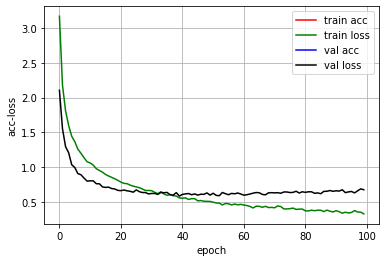

In [16]:
history.loss_plot('epoch')